<a href="https://colab.research.google.com/github/Trading-com-Dados/desenvolvimento_interno/blob/main/20220524_Backtesting_a_mao_PMF_code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300">

---
# **BACKTESTING  "*à mão*": o céu é o limite!** 
---
#### *Disclaimer:*
#### Este código foi elaborado para fins exclusivamente educacionais. O conteúdo aqui apresentado visa fornecer informações complementares para auxiliar o investidor na tomada de suas próprias decisões de investimento. Reforçando, nenhum tópico aqui abordado constitui qualquer tipo de indicação/oferta/solicitação de compra/venda de qualquer produto.
---



# **1. Bibliotecas utilizadas**

In [151]:
# Vamos utilizar a backtrader e a quantstats para conferir nossos backtests à mão

!pip install yfinance
!pip install ta
!pip install backtrader
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import numpy as np
import pandas as pd
from datetime import datetime
import pytz

import yfinance as yf
import ta
import backtrader as bt
import quantstats

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# **2. Definir o setup e baixar os dados**

## 2.1. Cruzamento do preço na média móvel

Neste primeiro exemplo, trabalharemos apenas com a ponta compradora, ou seja, venda apenas para fechar a posição<p>

**Sinal de entrada:**

Quando o preço cruzar a média móvel para cima: **COMPRA**<p>

1) Preço de fechamento do candle atual ficou acima da MM20p<p>
2) Preço de fechamento do candle anterior estava abaixo da MM20p<p>

**Sinal de saída (encerrar posição):**

Quando estiver comprado e o preço cruzar a média móvel para baixo: **VENDA**<p>

1) Preço de fechamento do candle atual ficou abaixo da MM20p<p>
2) Preço de fechamento do candle anterior estava acima da MM20p<p>

## 2.2. Importar dados com o Yahoo Finance

In [153]:
## Dados diários de Bitcoin para o ano de 2021 (criptomoedas são 7d/24h de negociações)

cotacoes_BTC_yf = yf.download("BTC-USD", start = '2021-01-01', end='2021-12-31', interval = "1d")
cotacoes_BTC_yf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299


## 2.3. Indicador MM e visualização do setup

In [154]:
## Cálculo Média Móvel de 20 períodos

cotacoes_BTC_yf['MMA20'] = cotacoes_BTC_yf['Close'].rolling(window=20).mean()
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20
Date,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN


In [155]:
# Visão geral dos dados e do indicador da Média Móvel

fig = go.Figure(go.Candlestick(name='Bitcoin_USD', x=cotacoes_BTC_yf.index, open=cotacoes_BTC_yf['Open'], high = cotacoes_BTC_yf['High'],
                               low=cotacoes_BTC_yf['Low'], close=cotacoes_BTC_yf['Close'],showlegend=False))

fig.add_trace(go.Scatter(name='MMA20', x=cotacoes_BTC_yf.index, y=cotacoes_BTC_yf.MMA20, marker_color='blue'))

fig.update_layout(title='', xaxis_title="<b>Data", yaxis_title="<b>Bitcoin (USD)", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=20,color="black"),paper_bgcolor="#f7f8fa")

fig.update_layout(xaxis_rangeslider_visible=False, margin=dict(l=120, r=20, t=20, b=20), template = 'simple_white',
                  width=1200,height=600,legend=dict(orientation="h",yanchor="bottom",y=0.9,xanchor="right",x=0.15))

fig.show()

In [156]:
# Visão geral dos dados e do indicador da Média Móvel

data_figure = cotacoes_BTC_yf[(cotacoes_BTC_yf.index>='2021-01-18') & (cotacoes_BTC_yf.index<='2021-02-05')]

fig = go.Figure(go.Candlestick(name='Bitcoin_USD', x=data_figure.index, open=data_figure['Open'], high = data_figure['High'],
                               low=data_figure['Low'], close=data_figure['Close'],showlegend=False))

fig.add_trace(go.Scatter(name='MMA20', x=data_figure.index, y=data_figure.MMA20, marker_color='blue'))

fig.add_annotation(x='2021-02-02',y=36000, xref="x",yref="y",text="<b>Candle_Sinal",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")

fig.update_layout(title='', xaxis_title="<b>Data", yaxis_title="<b>Bitcoin (USD)", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=20,color="black"),paper_bgcolor="#f7f8fa")

fig.update_layout(xaxis_rangeslider_visible=False, margin=dict(l=120, r=20, t=20, b=20), template = 'simple_white',
                  width=600,height=600,legend=dict(orientation="h",yanchor="bottom",y=0.9,xanchor="right",x=0.3),
                  yaxis=dict(range=[25000,50000]))

fig.show()

# **3. Localizar os sinais de entrada (candles sinalizadores) no dataframe**



Regra 1) Preço de fechamento do candle atual ficou acima da MM20<p>
Regra 2) Preço de fechamento do candle anterior estava abaixo da MM20

In [158]:
# REGRA 1: Verificar se o preço de fechamento é maior que  MM e gerar um booleano de TRUE or FALSE

cotacoes_BTC_yf['Buy_sign_R1'] = cotacoes_BTC_yf['Close'] > cotacoes_BTC_yf['MMA20']
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1
Date,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False


In [159]:
# REGRA 2: Verificar se o preço de fechamento do candle anterior estava menor que a MM
# Função shift para acessar candles específicos. Ex.: shift(2) = duas células acima no dataframe

cotacoes_BTC_yf['Buy_sign_R2'] = cotacoes_BTC_yf['Close'].shift(1) < cotacoes_BTC_yf['MMA20'].shift(1)
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2
Date,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False


In [160]:
# Caso as duas regras sejam verdadeiras, temos o nosso candle sinalizador

cotacoes_BTC_yf['Buy_cand_sign'] = (cotacoes_BTC_yf['Buy_sign_R1']==True) & (cotacoes_BTC_yf['Buy_sign_R2']==True)
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign
Date,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False,False


In [161]:
candles_sinalizadores = cotacoes_BTC_yf[cotacoes_BTC_yf['Buy_cand_sign']==True]
print("Foram observados",len(candles_sinalizadores),"candles sinalizadores considerando o período analisado")
candles_sinalizadores.head()

Foram observados 22 candles sinalizadores considerando o período analisado


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign
Date,,,,,,,,,,
2021-02-02,33533.199219,35896.882812,33489.218750,35510.289062,35510.289062,63088585433,34200.042285,True,True,True
2021-03-03,48415.816406,52535.136719,48274.320312,50538.242188,50538.242188,53220811975,49993.718750,True,True,True
2021-03-07,48918.679688,51384.367188,48918.679688,51206.691406,51206.691406,43137459378,50310.460352,True,True,True
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,57625587027,56693.754297,True,True,True
2021-04-08,56099.914062,58338.738281,55879.085938,58323.953125,58323.953125,53053855641,56934.878516,True,True,True


In [162]:
# Visualizar um range menor de datas para explorar o setup

data_figure = cotacoes_BTC_yf[(cotacoes_BTC_yf.index>='2021-03-01') & (cotacoes_BTC_yf.index<='2021-03-04')]

fig = go.Figure(go.Candlestick(name='Bitcoin_USD', x=data_figure.index, open=data_figure['Open'], high = data_figure['High'],
                               low=data_figure['Low'], close=data_figure['Close'],showlegend=False))

fig.add_trace(go.Scatter(name='MMA20', x=data_figure.index, y=data_figure.MMA20, marker_color='blue'))

fig.add_annotation(x='2021-03-03',y=52000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")

fig.update_layout(title='', xaxis_title="<b>Data", yaxis_title="<b>Bitcoin (USD)", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=20,color="black"),paper_bgcolor="#f7f8fa")

fig.update_layout(xaxis_rangeslider_visible=False, margin=dict(l=120, r=20, t=20, b=20), template = 'simple_white',
                  width=800,height=600,legend=dict(orientation="h",yanchor="bottom",y=0.9,xanchor="right",x=0.25))

fig.show()

# **4. Registrar os preços de compra (Buy at Market)**

Nesse caso, abriremos nossa posição na abertura do próximo candle, ou seja, assim q confirmamos o candle sinalizador

In [164]:
# Acessar o preço de abertura do próximo candle, dessa vez com shift (-1)
# É importante lembrar que o preço de compra só será válido em candles sinalizadores, mesmo aparecendo em todos os candles
# Isso evita que tenhamos que criar estruturas de repetição desnecessárias

cotacoes_BTC_yf['Buy_market'] = cotacoes_BTC_yf['Open'].shift(-1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market
Date,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,29376.455078
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,32129.408203
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,32810.949219
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,31977.041016
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,34013.613281
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,46490.605469


In [166]:
## GRÁFICO QUE DEMONSTRA AS ENTRADAS DA ESTRATÉGIA

fig = make_subplots(rows=1, cols=2)

## Figura 1

data_figure = cotacoes_BTC_yf[(cotacoes_BTC_yf.index>='2021-01-25') & (cotacoes_BTC_yf.index<='2021-02-25')]

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=data_figure.index, open=data_figure['Open'], high = data_figure['High'], low=data_figure['Low'], close=data_figure['Close']), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)",row=1, col=1)
fig.add_trace(go.Scatter(name='MMA20', x=data_figure.index, y=data_figure.MMA20, marker_color='blue'),row=1,col=1)
fig.add_vrect(x0='2021-01-30', x1='2021-02-03', fillcolor="green", opacity=0.25, line_width=0,row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-02-01'],y=[45000],mode="text",text="<b>Zoom",textposition="top center",showlegend=False),row=1, col=1)

## Figura 2
data_figure2 = cotacoes_BTC_yf[(cotacoes_BTC_yf.index>='2021-01-30') & (cotacoes_BTC_yf.index<='2021-02-05')]

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=data_figure2.index, open=data_figure2['Open'], high = data_figure2['High'], low=data_figure2['Low'], close=data_figure2['Close'],showlegend=False), row=1,col=2)
fig.add_annotation(x='2021-02-02',y=34500, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_annotation(x='2021-02-03 0:00',y=35512, xref="x",yref="y",text="<b>Entrada compra",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_trace(go.Scatter(name='MMA20', x=data_figure2.index, y=data_figure2.MMA20, marker_color='blue',showlegend=False),row=1,col=2)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,xaxis2_rangeslider_visible=False,template = 'simple_white',paper_bgcolor="#f7f8fa",
                  legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra Cruzamento Preço/Média',
                  font=dict(family="Arial, Arial, Arial",color="black"),width=1000 ,height=500)

fig.show()

# **5. Determinar o sinal de saída e registrar o preço**

Nessa estratégia de cruzamento de preço e MM, temos o que chamamos de trailing stop. <p>

Não temos alvos pré definidos (seja stop loss ou take profit). O encerramento da operação ocorrerá basicamente quando o preço cruzar para baixo a MM

In [167]:
# Vejamos agora se o candle fechou abaixo da MM
# Novamente, evitaremos criar estruturas de repetição desnecessárias. A análise final se fechou abaixo só será válida quando estivermos com posição aberta

cotacoes_BTC_yf['Sell_sign_R1'] = cotacoes_BTC_yf['Close'] < cotacoes_BTC_yf['MMA20']
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market,Sell_sign_R1
Date,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,29376.455078,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,32129.408203,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,32810.949219,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,31977.041016,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,34013.613281,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,50679.859375,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,47623.871094,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,46490.605469,True


In [168]:
# Para sabermos se estavamos posicionados, fechamento do candle anterior deveria estar acima da MM

cotacoes_BTC_yf['Sell_sign_R2'] = cotacoes_BTC_yf['Close'].shift(1) > cotacoes_BTC_yf['MMA20'].shift(1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market,Sell_sign_R1,Sell_sign_R2
Date,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,29376.455078,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,32129.408203,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,32810.949219,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,31977.041016,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,34013.613281,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,50679.859375,False,True
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,47623.871094,True,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,46490.605469,True,False


In [169]:
# Checando se temos um candle sinalizador de saída

cotacoes_BTC_yf['Sell_cand_sign'] = (cotacoes_BTC_yf.Sell_sign_R1==True) & (cotacoes_BTC_yf.Sell_sign_R2==True)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign
Date,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,29376.455078,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,32129.408203,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,32810.949219,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,31977.041016,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,34013.613281,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,50679.859375,False,True,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,47623.871094,True,True,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,46490.605469,True,False,False


In [170]:
# Considerando que o preço tenha fechado abaixo da média, registraremos o preço de abertura do próximo candle (shift -1), onde encerramos a posição

cotacoes_BTC_yf['Sell_market'] = cotacoes_BTC_yf['Open'].shift(-1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Sell_market
Date,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,29376.455078,False,False,False,29376.455078
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,32129.408203,False,False,False,32129.408203
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,32810.949219,False,False,False,32810.949219
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,31977.041016,False,False,False,31977.041016
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,34013.613281,False,False,False,34013.613281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,50679.859375,False,True,False,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,47623.871094,True,True,True,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,46490.605469,True,False,False,46490.605469


# **6. Organizar os preços de entrada (compra) e saída (venda)**

In [171]:
# Filtrar novamente apenas os candles sinalizadores

print('Tivemos',len(cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_cand_sign==True]),'entradas de compra')
cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_cand_sign==True].head()

Tivemos 22 entradas de compra


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Sell_market
Date,,,,,,,,,,,,,,,
2021-02-02,33533.199219,35896.882812,33489.218750,35510.289062,35510.289062,63088585433,34200.042285,True,True,True,35510.820312,False,False,False,35510.820312
2021-03-03,48415.816406,52535.136719,48274.320312,50538.242188,50538.242188,53220811975,49993.718750,True,True,True,50522.304688,False,False,False,50522.304688
2021-03-07,48918.679688,51384.367188,48918.679688,51206.691406,51206.691406,43137459378,50310.460352,True,True,True,51174.117188,False,False,False,51174.117188
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,57625587027,56693.754297,True,True,True,57750.132812,False,False,False,57750.132812
2021-04-08,56099.914062,58338.738281,55879.085938,58323.953125,58323.953125,53053855641,56934.878516,True,True,True,58326.562500,False,False,False,58326.562500


In [172]:
# Registrar os preços de compras

precos_compras = cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_cand_sign==True]['Buy_market']
precos_compras

Date
2021-02-02    35510.820312
2021-03-03    50522.304688
2021-03-07    51174.117188
2021-03-29    57750.132812
2021-04-08    58326.562500
2021-04-30    57714.664062
2021-05-05    57441.308594
2021-06-03    39242.484375
2021-06-09    37389.515625
2021-06-13    39016.968750
2021-06-29    35908.386719
2021-07-04    35284.343750
2021-07-11    34254.015625
2021-07-23    33593.730469
2021-09-01    48807.847656
2021-09-15    48158.906250
2021-09-18    48268.855469
2021-10-01    48137.468750
2021-10-28    60624.871094
2021-11-02    63254.335938
2021-11-07    63344.066406
2021-12-22    48626.343750
Name: Buy_market, dtype: float64

In [173]:
# Filtrar apenas as saídas

print('Tivemos',len(cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_cand_sign==True]),'saídas de venda')
cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_cand_sign==True].head()

Tivemos 22 saídas de venda


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Buy_market,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Sell_market
Date,,,,,,,,,,,,,,,
2021-02-25,49709.082031,51948.968750,47093.851562,47093.851562,47093.851562,54506565949,48866.722852,False,False,False,47180.464844,True,True,True,47180.464844
2021-03-04,50522.304688,51735.089844,47656.929688,48561.167969,48561.167969,52343816680,50046.534570,False,False,False,48527.031250,True,True,True,48527.031250
2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,56521454974,55253.118750,False,False,False,54511.660156,True,True,True,54511.660156
2021-04-07,58186.507812,58731.144531,55604.023438,56048.937500,56048.937500,75645303584,56936.013477,False,False,False,56099.914062,True,True,True,56099.914062
2021-04-18,60701.886719,61057.457031,52829.535156,56216.183594,56216.183594,97468872758,59541.941602,False,False,False,56191.585938,True,True,True,56191.585938


Note que tivemos 22 entradas e 22 saídas. Entretanto pode ser que esses valores fiquem diferentes em uma operação (veremos exemplos mais a frente no curso)<p>

Nesse caso, é preciso avaliar se ainda existe alguma posição aberta, se algum sinal de saída surgiu antes do primeiro sinal de entrada....

Note que no dia 11/01/2021 tivemos um "sinal de saída", já que o preço de fechamento estava acima no candle anterior e no dia 11/01 ficou abaixo.<p>
Porem não faz sentido um sinal de saída sem entrada. Vamos simplesmente remover esse sinal de saída inicial e combinar os dados de entradas e saída

In [174]:
# Registrar os preços de vendas (saídas)

precos_vendas = cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_cand_sign==True]['Sell_market']
precos_vendas

Date
2021-02-25    47180.464844
2021-03-04    48527.031250
2021-03-22    54511.660156
2021-04-07    56099.914062
2021-04-18    56191.585938
2021-05-04    53252.164062
2021-05-12    49735.433594
2021-06-04    36880.156250
2021-06-12    35555.789062
2021-06-18    35854.527344
2021-06-30    35035.984375
2021-07-05    33723.507812
2021-07-12    33125.468750
2021-08-30    47024.339844
2021-09-07    46827.761719
2021-09-16    47771.003906
2021-09-19    47261.406250
2021-10-27    58470.730469
2021-11-01    60963.253906
2021-11-04    61460.078125
2021-11-16    60139.621094
2021-12-28    47623.871094
Name: Sell_market, dtype: float64

In [175]:
# Agora podemos visualizar todas as entradas e saídas de forma clara

all_trades = pd.concat([precos_compras,precos_vendas],axis=1)
all_trades

,Buy_market,Sell_market
Date,,
2021-02-02,35510.820312,NaN
2021-02-25,NaN,47180.464844
2021-03-03,50522.304688,NaN
2021-03-04,NaN,48527.031250
2021-03-07,51174.117188,NaN
2021-03-22,NaN,54511.660156
2021-03-29,57750.132812,NaN
2021-04-07,NaN,56099.914062
2021-04-08,58326.562500,NaN


# **7. Calcular algumas métricas bem simples de backtesting**

## **7.1. Resultado líquido**

Simplesmente a diferença entre os lucros brutos e as perdas brutas.<p>
Neste parâmetro, pode fazer diferença como estão sendo alocadas as entradas.<p>

Ex.1) Nosso caso, onde a qtd do lote na entrada é baseada no número de ações/contratos. A qtd é fixa e portanto os ganhos líquidos não representam exatamente o ganho %<p>
Ex.2) Compra/vendas são baseadas no caixa total / preço ativo. Assim, a qtd de ativos varia ao longo das operações, mas os resultados estão mais próximos de uma %

In [177]:
# Juntando os dataframes ignorando o index

df_compra_venda = pd.DataFrame(zip(precos_compras,precos_vendas),columns=['Compra','Venda'])
df_compra_venda.head()

,Compra,Venda
0,35510.820312,47180.464844
1,50522.304688,48527.031250
2,51174.117188,54511.660156
3,57750.132812,56099.914062
4,58326.562500,56191.585938


In [178]:
# Calcular o resultado nominal e percentual das negociações

df_compra_venda['Resultado'] = df_compra_venda['Venda'] - df_compra_venda['Compra']
df_compra_venda['Resultado_%'] = (df_compra_venda['Venda'] - df_compra_venda['Compra']) / df_compra_venda['Compra'] * 100
df_compra_venda

,Compra,Venda,Resultado,Resultado_%
0,35510.820312,47180.464844,11669.644531,32.862222
1,50522.304688,48527.031250,-1995.273438,-3.949292
2,51174.117188,54511.660156,3337.542969,6.521936
3,57750.132812,56099.914062,-1650.218750,-2.857515
4,58326.562500,56191.585938,-2134.976562,-3.660385
5,57714.664062,53252.164062,-4462.500000,-7.732004
6,57441.308594,49735.433594,-7705.875000,-13.415215
7,39242.484375,36880.156250,-2362.328125,-6.019823
8,37389.515625,35555.789062,-1833.726562,-4.904387
9,39016.968750,35854.527344,-3162.441406,-8.105298


In [179]:
# Somando o resultado nominal, temos o lucro líquido (negativo indicando prejuízo)

Resultado_liquido = sum(df_compra_venda.Resultado)
Resultado_liquido

863.703125

In [180]:
# Veja a diferença se estivesse entrado sempre com a mesma qtd financeira e nao qt do ativo

print(Resultado_liquido/np.mean(df_compra_venda['Compra'])*100)
sum(df_compra_venda['Resultado_%'])

1.8056190165537853


23.689823423640952

## **7.2. Evolução patrimonial**

Dá uma ideia geral de como o patrimônio evoluiu ao longo do tempo. Procurar consistencia e evitar "montanhas-russas"

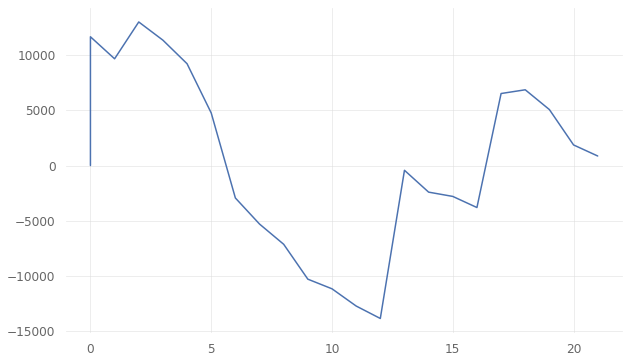

In [181]:
# Utilizar a função cumsum que acumula a soma dos resultados absolutos na coluna 'Resultado'

evolucao_patrimonio = df_compra_venda['Resultado'].cumsum()
evolucao_patrimonio = pd.concat([pd.Series([0]), evolucao_patrimonio])
evolucao_patrimonio.plot()

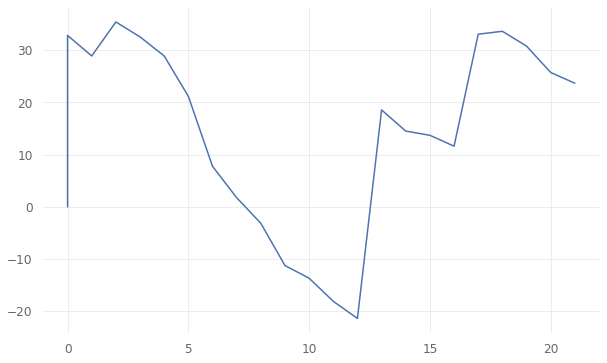

In [182]:
# Utilizando a soma dos resultados percentuais

evolucao_patrimonio_perc = df_compra_venda['Resultado_%'].cumsum()
evolucao_patrimonio_perc = pd.concat([pd.Series([0]), evolucao_patrimonio_perc])
evolucao_patrimonio_perc.plot()

## **7.3. Taxa de Acerto**

Porcentagem de trades com gain. Parâmetro muito comum, mas deve ser complementar. Individualmente não conta muito da história (mesmo ganhando pouco, quando ganhar, ganhar muito!)

In [183]:
# Uma forma menos usual de saber qts positivos/negativos

results_binning = np.sign(df_compra_venda['Resultado']).value_counts()
results_binning

-1.0    17
 1.0     5
Name: Resultado, dtype: int64

In [185]:
# Como é um pandas.series, o valor indexado refere-se não à posição, mas ao valor (se quisesse os negativos usaria -1 ao invés de 0)

Taxa_acerto = results_binning[1]/sum(results_binning)
Taxa_acerto

0.22727272727272727

## **7.4. Média de ganhos e perdas**

Complementar ao anterior. Verificar se não está com o viés do apostador (segurar muito no loss e se livrar logo no gain)

In [186]:
# Classificar em positivo ou negativo e usar o groupby para somar cada classe

df_compra_venda['Result_bin'] = np.sign(df_compra_venda['Resultado'])
pos_neg_medios = df_compra_venda.groupby('Result_bin').Resultado.mean()
pos_neg_medios

Result_bin
-1.0   -2249.749311
 1.0    7821.888281
Name: Resultado, dtype: float64

## **7.5. Fator de lucro**

Razão entre os ganhos e as perdas (qts vezes o lucro bruto é maior que a perda bruta?)

In [187]:
# Classificar em positivo ou negativo e usar o groupby para somar cada classe

df_compra_venda['Result_bin'] = np.sign(df_compra_venda['Resultado'])
pos_neg_results = df_compra_venda.groupby('Result_bin').Resultado.sum()
pos_neg_results

Result_bin
-1.0   -38245.738281
 1.0    39109.441406
Name: Resultado, dtype: float64

In [188]:
# Em valor absoluto, calcular a razão entre positivos e negativos
# Quanto maior a razão acima de 1, mais os ganhos superaram as perdas

abs(pos_neg_results[1]/pos_neg_results[-1])

1.022582989996128

In [189]:
# Evoluçao do patrimônio nominal,  e gráfico de barras com resultado de cada trade

fig = make_subplots(rows=3, cols=1,vertical_spacing = 0.05)

fig.add_trace(go.Scatter(x=evolucao_patrimonio.index, y=evolucao_patrimonio,name='Evolução Patrimonio'),row=1,col=1)
fig.add_hline(y=0, line_width=3, line_dash="dash", line_color="black",row=1,col=1)

fig.add_trace(go.Scatter(x=evolucao_patrimonio_perc.index, y=evolucao_patrimonio_perc,name='Evolução Patrimonio %'),row=2,col=1)
fig.add_hline(y=0, line_width=3, line_dash="dash", line_color="black",row=2,col=1)

fig.add_trace(go.Bar(x=df_compra_venda.index, y=df_compra_venda['Resultado'], name='PnL'), row=3,col=1)
fig.add_hline(y=0, line_width=3, line_color="black",row=3,col=1)

fig.update_yaxes(title_text="<b> Valor nominal rendimentos (USD)", row=1, col=1)
fig.update_yaxes(title_text="<b> Operações PnL (USD)", row=3, col=1)
fig.update_layout(title_text='Evolução do Patrimônio e PnL')

fig.update_layout(title='', xaxis3_title="<b>Número de operações", yaxis1_title="<b>Patrimônio acumulado (USD)",
                  yaxis2_title="<b>Patrimônio acumulado (%)", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=10,color="black"),paper_bgcolor="#f7f8fa")

fig.update_layout(xaxis_rangeslider_visible=False, margin=dict(l=120, r=20, t=20, b=10), template = 'simple_white',
                  width=500,height=600,showlegend=False)

fig.show()